In [10]:
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import multiprocessing as mp
import glob
import sys
from functools import partial
from sklearn.cluster import DBSCAN
import matplotlib as mpl
import collections
from collections import defaultdict
from skimage.filters import scharr
import itertools
import pickle
import warnings

In [55]:
class PIL():
    '''This class creates a PIL detector which can be called for fitting PIL on any Bz image or an entire hdf5 file.
        
       Summary on the class "PIL":
       
       For each image of the vertical component of the magnetic field, namely the image of "Bz", we want to find the 
       contour of Bz==0 that separates the strong positive magnetic polars and the associated negative polars, which 
       is called the Polarity Inversion Line(PIL). Physicists are interested in the local magnetic field features 
       around the PIL.
       
       In a pixelized image, the pixels that consist of the PIL should be those pixels that have a large Bz gradient in 
       its neighborhood. And finding these points is analogous to the edge detection task in the image processing field.
       So by applying an edge detection filter upon each Bz image, we could find the candidate pixels of the PIL. And by 
       further applying a clustering algorithm on the candidate pixels, we are able to locate several PIL segments in the
       image. Finally, one could retain, as many as one wanted, the PILs with large average gradients for future purposes.
       
       The class PIL is a parameterized PIL detector that combines the data preparation, edge detection, clustering and 
       parallelized training, and visualization procedures. It can be applied to a piece of image in numpy ndarray form, 
       and even an entire hdf5 file with rather fast implementation.
    
    '''
    
    def __init__(self,edge_retain=0.005,polar_threshold=0.50,radius=12,min_samples=5):
        '''Initialize the PIL detector
        
           Params:
           edge_retain: The fraction of candidate PIL pixels of the input image. Range from 0 to 1. Float number.
                        What fraction of the pixels of the whole input image can be considered as a candidate for PIL. 
                        The larger the amount is, the more pixels there will be for the PIL. The default amount is 0.005
                        which corresponds to 0.5% of all pixels in the input image. These pixels are the pixels with the 
                        largest local gradient. By specifying the edge_retain to be too large, we may include many irrelevant
                        pixels when drawing the PIL. By setting the parameter to be too small, we may lose some pixels on
                        the true PIL. The best way to tune the parameter is to use the .visualize() method to check visually. 
                        Generally speaking, each image won't have more than 1% of its pixels as PIL.
                        
           polar_threshold: The strong polar threshold. Range from 0 to 1. Float number.
                            The quantile of the magnitude of the vertical component above which a pixel is considered as 
                            a strong polar. Basically, each image is decomposed into a positive image and a complementing
                            negative image. In a positive image, all negative image pixels are coerced to 0, and vice versa.
                            In the positive image, for instance, all pixels' values are ranked from the smallest to the 
                            largest, and all the pixels that are ranking at the quantile no greater than polar_threshold are
                            further coerced to 0. The same procedure applies to the negative image. And the positive and 
                            negative image are put back together as a sparser image, upon which the edge detector will be
                            applied. Setting the parameter too small can lead to many weaker polars being considered when
                            drawing the PIL.
                            
           radius: The maximum pixel distance between two pixels that make the pixels being considered as on the same PIL. Positive Integer. 
                   The larger the quantity, the less PIL segments will be drawn in the image, but maybe two originally 
                   separated PILs will be considered mistakenly as a single PIL.
           
           min_samples: The minimum number of pixels that a PIL segment should contain. Positive Integer.
                        For a set of pixels to be considered as a PIL, one need at least min_samples in the set. By setting
                        the parameter to be too large, we may mistakenly overlook those shorter PIL. On the contrast, we may
                        include too many noisy PILs that are not ideal.
        '''
        # take records for each of the parameter
        self.edge_retain = edge_retain
        self.polar_threshold = polar_threshold*100
        self.radius = radius
        self.min_samples = min_samples
        self.window_size = 5 # see .data_preparation() method for reference
        self.DBSCAN = DBSCAN(eps=self.radius,min_samples=self.min_samples) # set up the DBSCAN cluster operator for pixels clustering
        self.PIL_segment = defaultdict(dict) # the default PIL result for an image is an empty dictionary
        self.global_mode=False # an indicator for distringuishing whether the code is run on a single image or on a whole file
        self.invalid_image=False # a flag indicating whether the image can be processed
        # images can be invalide due to:
        # a. no positive or no negative pixels
        # b. more than 1/5 of the pixels are NaN
        
    def Image_Decompose(self,image):
        '''Data preparation method, a submethod for .data_preparation() method.
           
           Params:
           image: Input image. Numpy array.
                  Shape = [height,width]
           
           Output:
           pos_weight: Numpy ndarray.
                       Shape = [num_positive_pixels,]
                       
                       An array of all positive pixel values of the input image.
                       
           neg_weight: Numpy ndarray.
                       Shape = [num_negative_pixels,]
                       
                       An array of all negative pixel values of the input image.
        '''
        image = np.nan_to_num(image) # fill the NaN value in an image as 0
        
        pos_weight = np.where(image>1e-6,image,0) # create a positive image component
        neg_weight = np.where(image<-1e-6,image,0) # create a negative image component
        
        pos_weight, neg_weight = np.ndarray.flatten(pos_weight), np.ndarray.flatten(neg_weight) # collapse both image into 1-D
        
        pos_weight = pos_weight[np.nonzero(pos_weight)] # remove all 0s in the pos_weight
        neg_weight = neg_weight[np.nonzero(neg_weight)] # remove all 0s in the neg_weight
    
        if pos_weight.shape[0]==0 or neg_weight.shape[0]==0:
            self.invalid_image = True # if there is either no positive or no negative pixel, we consider it as an invalid image, and output an empty dictionary
            warnings.warn(message="Missing positive or negative polar in the image.")
            
        if (pos_weight.shape[0]+neg_weight.shape[0])<(image.shape[0]*image.shape[1])*(1/5):
            self.invalid_image = True # if there are more than one-fifth NaN pixels in the image, do not process the image
            warnings.warn(message="Too many missing values in the image.")
            
        return pos_weight, neg_weight
    
    def data_preparation(self,image,window_size=5):
        '''Data preparation method, a submethod for the .fit() and .fitFile() method.
        
           Params:
           image: Input image. Numpy array.
                  Shape = [height,width]
           
           window_size: The range of a pixel's neighborhood. Odd number integer. No smaller than 3.
                        For each pixel in the input image, we consider a window_size*window_size, 5*5 by default, subimage with
                        the pixel of interest being at the center. 
                        
           Output:
           image_new: Output image ready for edge detection. Numpy array.
                      Shape = [height, width], same as the input image.
                      
                      For each pixel in the original image, one consider the local maximum and local minimum of the pixel within
                      its neighborhood. If both the local maximum and minimum passed the quantile threshold sepecified by 
                      self.polar_threshold in the corresponding positive and negative image, the pixel's value is retained,
                      otherwise the pixel is put to zero.
                      
                      As a result, the output image only contains those pixels with both a strong positive and a strong negative
                      polar within its neighborhood. This helps exclude those pixels with a strong positive/negative polar but 
                      no associative polar of the opposite polarity. So these pixels in the output image is a superset of PIL pixels.
        '''
                   
        image = np.nan_to_num(image) # fill all NaN in the image as 0
        self.window_size = window_size # store the window_size attribute
        
        pos_weight, neg_weight = self.Image_Decompose(image)
        
        if self.invalid_image==False:
    
            height = image.shape[0]
            width = image.shape[1]
            
            pos_threshold = np.percentile(pos_weight, q=self.polar_threshold) # find the top quantile value of all positive pixels
            neg_threshold = np.percentile(np.abs(neg_weight), q=self.polar_threshold) # find the top quantile value of all negative pixels
    
            pad_size = int((window_size-1)/2)
            image_padded = np.pad(image,((pad_size,pad_size),(pad_size,pad_size)),'constant') # pad the image to make sure the output image has the same shape as the input image
    
            image_max = np.zeros((height,width)) # an image with each pixel storing its local maximum
            image_min = np.zeros((height,width)) # an image with each pixel storing its local minimum
            image_new = np.zeros((height,width)) # output image
    
    
            for i in range(height):
                for j in range(width):
                    x = i+pad_size
                    y = j+pad_size
            
                    window = image_padded[(x-pad_size):(x+pad_size+1),(y-pad_size):(y+pad_size+1)] # the neighborhood subimage for each pixel
                    maximum = np.amax(window) # find the local maximum
                    minimum = np.amin(window) # find the local minimum
            
                    image_max[i,j] = maximum
                    image_min[i,j] = minimum
                    if maximum>pos_threshold and minimum<-(neg_threshold): # retains the pixel value only if it has both a strong positive polar and a strong negative polar in its neighborhood subimage
                        image_new[i,j] = image[i,j]
                
            return image_new
        else:
            return None
    
    def fit(self,image,select=1,window_size=5):
        ''' Fit the whole PIL pipeline on the input image. Including the edge detection, clustering and filtering steps. Given
            an input image, the fit method find all PIL pixels, and return two arrays containing information of the selected 
            PILs with the largest average local magnetic field gradient. Each PIL's information includes its corresponding pixels
            and average local gradients.
            
            Params:
            image: Input image. Numpy array.
                   Shape = [height,width]
            
                   Original image upon which one wants to locate several PILs.
            
            select: Number of PILs to record. Positive Integer. Default is 1.
                    
                    Out of all PIL segments detected, how many of them are going to be recorded. All PIL segments are ranked 
                    according to their pixel-average local magnetic gradient, and only the PILs with the largest average gradient
                    are recorded.
            
            window_size: The range of a pixel's neighborhood. Odd number integer. No smaller than 3.
                         See description in method .data_preparation()
            
            Output: 
            PIL_segment: Information of the pixels of the selected PIL segments. Dictionary.
                       
                       The output is a dictionary: PIL_segment[segment_label]['coor'] = array of the coordinates of all pixels of the segment 
                                                   PIL_segment[segment_label]['gradient'] = average gradient of the PIL segment
                                                   
                       PIL segment labels are ranked in a descending order based on the average gradient.
        '''
        
        image = self.data_preparation(image,window_size=window_size) # only retain the pixels with both a strong positive and a strong negative polar in the neighborhood
        if self.invalid_image==False:
            edge = scharr(image) # edge detection 
        
            threshold = np.percentile(edge,q=100*(1-self.edge_retain)) # calculates the top quantile for local gradients
    
            # take records of the coordinates of all pixels that have a very large local graidents.
            edge = np.where(edge>threshold,edge,0)
            pixel_coor = np.transpose(np.nonzero(edge)) # these are the PIL candidates' coordinates
            pixel_weight = list(map(lambda x: edge[x[0],x[1]],pixel_coor)) # the corresponding local gradient values for the PIL candidates
        
            thecluster = self.DBSCAN.fit_predict(X=pixel_coor) # cluster the PIL candidates into possibly several PIL segments.
    
            # now we are going to select the top few clusters with the largest average gradient
            N = len(set(thecluster)) # number of PIL segments
            cluster_coor = defaultdict(list) # a dictionary: cluster_coor[PIL_segment_label] = list of pixels of the PIL segment
            cluster_gradient = defaultdict(list) # a dictionary: cluster_gradient[PIL_segment_label] = list of pixels' gradient of the PIL segment
        
            whole_data = list(zip(pixel_coor,pixel_weight,thecluster))
            new_data = []
        
            # since there might be some PIL candidate pixels that do not even form a PIL segment, we should exclude all of these noisy points
            if (-1) in thecluster:
                N = N-1 
            for item in whole_data:
                if item[2]!=-1:
                    new_data.append(item)
                    
            if N!=0: # if all candidate points are noises, then do nothing

                # record the coordinates information and gradient information for each of the PIL segment, namely each cluster
                for c in range(N):
                    cluster_coor[c] = [item[0] for item in new_data if item[2]==c]
                    cluster_gradient[c] = [item[1] for item in new_data if item[2]==c]
        
                # calculate the segment average gradient and rank all PILs, select the top few PIL segments for final output
                cluster_ave_gradient = [np.average(np.array(cluster_gradient[c])) for c in cluster_gradient]
        
                if len(cluster_ave_gradient)>select:
                    top = np.argsort(cluster_ave_gradient)[-(select):] 
                else:
                    top = np.argsort(cluster_ave_gradient)
        
                # record the coordinate information for the selected PIL segments
                PIL_segment = defaultdict(dict)
                order = list(reversed(top))
        
                for c in range(len(top)):
                    k = order[c]
                    coor = cluster_coor[k] # the list of coordinate of one of the top PIL segment
                    PIL_segment[c]['coor'] = np.array(coor)
                    PIL_segment[c]['weight'] = cluster_ave_gradient[k]
    
                self.PIL_segment = PIL_segment # PIL results
                self.N = N # total PIL segments found
                return self.PIL_segment
            
            elif self.global_mode==False:
                print("No PIL in the image!")
                return self.PIL_segment # return an empty dictionary
        else:
            return self.PIL_segment # if the image is not valid, only return an emtpy dictionary
    
    def visualize(self,image,select=3,window_size=5,savefigure=False,figname='PIL'):
        ''' A visualization method for showing the original data, the data input, and the PIL.
            
            Params:
            image: the original data image.
            
            select: the number of PIL segments to show.
            
            window_size: the range of a pixel's neighborhood, see documentation on .data_praparation() method for reference
            
            Output:
            A 1*3 figure with left panel being the grayscale heatmap for the original data, the middle panel being the 
            result of the .data_preparation() method, which is exactly the data input into the .fit() method, and the 
            right panel being the corresponding PILs founded. The parameters for the .fit() method should be set up 
            when a PIL() object is being created.
            
        '''
        
        image_new = self.data_preparation(image,window_size) # calculate the prepared image
        
        if self.invalid_image==False:       
            PILs = self.fit(image,select=select,window_size=window_size) # the PIL segments
            points = [] # the coordinates for all PIL points
            weights = [] # the corresponding average gradient of the PIL segment to which the PIl point belongs to
            PIL_image = np.zeros_like(image)
            
            # we are going to mark each PIL segments with a color that corresponds to its average gradient so as to show 
            # the relative strength of each PIL segment
            if len(PILs)>0:# if there is any PIL segments founded
                for k in PILs:
                    coors = PILs[k]['coor']
                    weight = PILs[k]['weight']
                    
                    for p in range(coors.shape[0]):
                        points.append(coors[p])
                        weights.append(weight)
                for p in range(len(points)):
                    thepoint = points[p]
                    PIL_image[thepoint[0],thepoint[1]] = weights[p]
            
            
            fig = plt.subplots(nrows=1, ncols=3)
            cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True) # use the grayscale color map

            plt.subplot(1, 3, 1)
            seaborn.heatmap(image, center=0, cmap=cmap,cbar=False,xticklabels=False, yticklabels=False)
            
            plt.subplot(1, 3, 2)
            seaborn.heatmap(image_new, center=0, cmap=cmap,cbar=False,xticklabels=False, yticklabels=False)
            
            plt.subplot(1, 3, 3)
            seaborn.heatmap(PIL_image, center=0, cmap=cmap,cbar=False,xticklabels=False, yticklabels=False)
                
            if savefigure==True:
                plt.savefig(figname+'.pdf')
            else:
                plt.show()

In [54]:
def PIL_fit(image,edge_retain=0.003,polar_threshold=0.50,radius=12,min_samples=5,select=1,window_size=5,image_index=-1):
    ''' An explicit function, instead of a class method, for fitting PIL over an image. Basically a class method wrapper.
        
        Params:
        image, edge_retain, polar_threshold, radius, min_samples, select, window_size: see the PIL class documentation.
        
        image_index: the index of the image processed by this function. Useful if the multiprocessing of several frames is 
                     done asynchronously.
        
    '''
    PIL_detector = PIL(edge_retain=edge_retain,polar_threshold=polar_threshold,radius=radius,min_samples=min_samples)
    PIL_detector.global_mode = True
    result = PIL_detector.fit(image,select=select,window_size=window_size)
    
    return result, image_index

def PIL_fit_parallel(f,core=8,global_threshold=0.3,edge_retain=0.003,polar_threshold=0.50,
                     radius=12,min_samples=5,select=1,window_size=5,filename='Nil'):
    ''' Fit the PIL pipeline over all images in a numpy array file f/ hdf5 file f. For current python environment,
            it is unsatisfactory that the class method .fit() cannot be made parallelized as a separate class method
            since the multiprocessing module is not compatible with the pickle module. So we need to make the parallelization
            explicitly in a process-oriented way.
        
            Params:
            f: Input file. A file object.     
               The input file for the whole HARP region, could be a numpy .npy file, or a .hdf5 file.
               For npy file, its shape should be [num_frames,height,width]
               For hdf5 file, its directory structure should be 'video0'->'frameXXX'->'channels'-> the Bz Image
            
            core: The number of processing cores for doing the parallalization.
            
            global_threshold: The percentile threshold used for selecting PILs throughout the whole video. Range from 0 to 1.
                              When each image of the file has its PILs founded, all PILs throughout the video are compared
                              based on their corresponding average gradient. And the quantile of the average gradient at
                              the global_threshold is used to delete those weak PILs that have an average gradient that is
                              below the quantile. The smaller it is, the more PILs will be retained for each image.
            
            edge_retain, polar_threshold, radius, min_samples, select, window_size: see the PIL class documentation.
            
            filename: The filename for saving the output file. No extensions needed.
            
            Output:
            PIL_file: In case of a numpy array input, output a pickled dictionary. In cased of hdf5 file, output a corresponding
                      hdf5. Saved in the same folder.                      
        '''
    
    pool = mp.Pool(processes=core)
    process_input = []
    
    if type(f)==np.ndarray:
        for i in range(f.shape[0]):
            the_input = [f[i],edge_retain,polar_threshold,radius,min_samples,select,window_size,i]
            process_input.append(the_input)
        
    if type(f)==h5py._hl.files.File:
        # in case of an hdf5 input, output an hdf5 file with the same group structure 
        video = f['video0']
        framelist = list(video.keys())
        frames = sorted(framelist, key=lambda x: int(x[5:]), reverse=False) # order all the frames chronologically
        images = [video[p]['channels'][:,:,2] for p in frames] # a list of input images
        process_input = []

        for i in range(len(frames)):
            the_input = [images[i],edge_retain,polar_threshold,radius,min_samples,select,window_size,frames[i]]
            process_input.append(the_input) 
    
    # parallel training        
    results = [pool.apply_async(PIL_fit,t) for t in process_input]
    output = [p.get() for p in results]
    
    # compare all frames' PIL segments' average gradient and delete those PILs with very small gradient
    all_gradient = [] # a list of PILs' gradients
        
    for item in output:
        PIL_segment = item[0] # retain the result from an image
        if len(PIL_segment.keys())>0: # check if any PILs are found in the image
            for segment in PIL_segment:
                all_gradient.append(PIL_segment[segment]['weight']) # store the weight value in all_gradient so as to do global thresholding on all images.
        
    threshold = np.percentile(np.array(all_gradient),q=100*global_threshold) # this threshold is to cut off those weak PILs

    
    # create output file
    if type(f)==np.ndarray:  
        final_result = defaultdict(dict)        
        for item in output:
            thekey = item[1]
            PIL_segment = item[0]
            if len(PIL_segment.keys())==0: # if no PIL for the image
                final_result[thekey] = PIL_segment # store the result in a dictionary
            else:
                L = list(PIL_segment)
                for line in L: # if there is any PIL for the image
                    if PIL_segment[line]['weight']>threshold:
                        continue
                    else:
                        del PIL_segment[line] # if the gradient for the PIL is too small, throw the PIL away
                
                final_result[thekey] = PIL_segment # store the result in a dictionary
            
        with open(filename + 'PIL.pkl', 'wb') as f:
            pickle.dump(final_result, f, pickle.HIGHEST_PROTOCOL)
        print("Output Created")
        
    
    if type(f)==h5py._hl.files.File:    
        # create the new hdf5 file with the same structure
        filename = filename+'PIL.hdf5'
        PILfile = h5py.File(filename,mode='w')
        PILfile.create_group(name='video0')
        newvideo = PILfile['video0']
        
        for i in range(len(output)):
            framename = output[i][1]
            newvideo.create_group(name=framename)
            newframe = newvideo[framename]
            
            PIL_segment = output[i][0] # the PIL segment dictionary object
            if len(PIL_segment)==0:
                newframe.create_dataset(name='PIL',data=PIL_segment)
            else:
                L = list(PIL_segment)
                for line in L: # if there is any PIL for the image
                    if PIL_segment[line]['weight']>threshold:
                        continue
                    else:
                        del PIL_segment[line] # if the gradient for the PIL is too small, throw the PIL away
                newframe.create_dataset(name='PIL',data=PIL_segment) # to access a certain frames' PIL: f['video0']['frameX']['PIL'][PIL_segment_num]['coor'/'weight']
        PILfile.close()


In [46]:
tool = PIL(edge_retain=0.003,polar_threshold=0.50,radius=12,min_samples=5)

In [17]:
data = np.load('HARP377.npy')
test_data = data[0:20]

In [51]:
image = data[600]

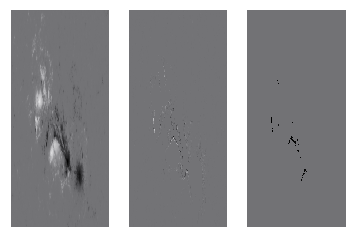

In [53]:
tool.visualize(image,select=5)

In [ ]:
result = tool.fitFile(test_data,select=2,window_size=5)

In [13]:
tool.fit(image,select=1)

In [14]:
tool.PIL_segment

defaultdict(dict, {0: {'coor': array([[222, 441],
                     [222, 442],
                     [223, 441],
                     ...,
                     [259, 457],
                     [259, 458],
                     [259, 459]], dtype=int64), 'weight': 92.13377611488512}})

In [ ]:
class PIL_global(PIL):
    ''' The previous class PIL() works on images. While it is very useful to locate the PIL for each image of interest,
        it is not an ideal approach when we are dealing with a complete magnetic field history of a video for a HARP region.
        More specifically, when we are trying to locate the PIL for each image of the video, we use a global_threshold 
        parameter in the PIL() class to compare all PILs found in each image altogether and then only keep a certain 
        percentage of all PILs for the whole video. But when generating candidate PILs, we still only work on images 
        individually. In this class of PIL_global(), we are going to work on videos directly, and preprocess input for 
        all images altogether, and finally locate PILs for all image altogether. Hopefully, the results will be improved. 
        Since this time, the strength of a polar in a certain Bz image is determined by comparing it with all polars in the
        whole video instead of just other polars within the same image.
        
        Params:
        edge_retain, radius and min_samples: see documentation for the .__init__() method of the PIL() class
        
        polar_threshold: The strong polar threshold. Range from 0 to 1. Float number.
                         The quantile of the magnitude of the vertical component above which a pixel is considered as 
                         a strong polar. Basically, each video is decomposed into a positive video and negative video.
                         For a positive video, each frame of it only contains the positive pixels for that frame in the 
                         original video and all negative pixels are coerced to 0. The same principle applies to the definition
                         of the negative video. And for a positive video, all pixels of all frames are ranked altogether, and 
                         the strong positive pixels is defined as the pixels above the polar_threshold quantile in this
                         video-level pixel rank.
    '''
    
    def hdf5_to_ndarray(self,f):
        ''' For other methods under this class, one deals data with a numpy-ndarray data format. For any hdf5 data input,
            this method enables the user to convert the data format to numpy array.
        '''
        array_data = None
        
        
        
    def video_data_decompose(self,f):
        ''' In this 
        
        '''
        